```
Copyright 2023 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

# An example implementing the three key questions

March and Olsen (2011) posit that humans generally act as though they choose their actions by answering three key questions:

1. What kind of situation is this?
2. What kind of person am I?
3. What does a person such as I do in a situation such as this?

The agents used in this example implement these components. The premise of the simulation is that 4 friends are stuck at a snowed in pub. Also, it has just come to light that Alice stole Bob's car and crashed it.


## Init and import

In [1]:
#@Imports
import sys
import os
path = os.path.abspath('..')
if path not in sys.path:
  sys.path.insert(0, path)

%load_ext autoreload

import collections
import concurrent.futures
import datetime
import json
import termcolor
import re

import numpy as np

from IPython import display

from concordia.agents import basic_agent
from concordia.components import agent as components
from concordia import components as generic_components
from concordia.associative_memory import associative_memory
from concordia.associative_memory import blank_memories
from concordia.associative_memory import formative_memories
from concordia.associative_memory import importance_function
from concordia.clocks import game_clock
from concordia.components import game_master as gm_components
from concordia.environment import game_master
from concordia.metrics import goal_achievement
from concordia.metrics import common_sense_morality
from concordia.metrics import opinion_of_others
from concordia.typing import agent as simulacrum_agent
from concordia.utils import html as html_lib
from concordia.utils import measurements as measurements_lib
from concordia.utils import plotting

from examples.custom_components.setup import model_setup, measurement_setup

In [2]:
#@Model Setup
model, embedder = model_setup('llama3', local_models=True, streaming=False)
TIME_STEP = datetime.timedelta(minutes=20)
SETUP_TIME = datetime.datetime(hour=18, year=2024, month=10, day=1)
measurements, clock = measurement_setup(
  SETUP_TIME= SETUP_TIME, 
  time_step = TIME_STEP)

#@title Importance models
importance_model = importance_function.ConstantImportanceModel()
importance_model_gm = importance_function.ConstantImportanceModel()

## Configuring the generic knowledge of players and GM.

In [3]:
# @title Generic memories are memories that all players and GM share.

shared_memories = [
    'There is a pub called The Sundrop Saloon.',
    "Alice stole Bob's car and crashed it.",
    ('Alice, Bob, Charlie and Dorothy always spend their evenings at the ' +
     'Sundrop Saloon.')
]

# The generic context will be used for the NPC context. It reflects general
# knowledge and is possessed by all characters.
shared_context = model.sample_text(
    'Summarize the following passage in a concise and insightful fashion:\n'
    + '\n'.join(shared_memories)
    + '\n'
    + 'Summary:'
)
print(shared_context)


Here is a concise and insightful summary of the passage:

The Sundrop Saloon is a local gathering spot where friends Alice, Bob, Charlie, and Dorothy frequently socialize in the evenings. However, tensions rise when Alice's reckless behavior takes a dramatic turn by stealing Bob's car and crashing it, potentially disrupting their social dynamics and relationships at the saloon.


## Configure and build the players

---



In [4]:
blank_memory_factory = blank_memories.MemoryFactory(
    model=model,
    embedder=embedder,
    importance=importance_model.importance,
    clock_now=clock.now,
)

formative_memory_factory = formative_memories.FormativeMemoryFactory(
    model=model,
    shared_memories=shared_memories,
    blank_memory_factory_call=blank_memory_factory.make_blank_memory,
)

In [5]:
#@title Creating character backgrounds, goals and traits. Modify to explore how it influences the outcomes
NUM_PLAYERS = 4

scenario_premise = [
    (
        'Alice, Bob, Charlie and Dorothy are at the Sundrop Saloon. There '
        + 'is a snow storm and they have to wait it out inside.'
    ),
]
player_configs = [
    formative_memories.AgentConfig(
        name='Alice',
        gender='female',
        goal='Alice wants Bob to accept his car is trashed and back off.',
        context=shared_context,
        traits='responsibility: low; aggression: high',
    ),
    formative_memories.AgentConfig(
        name='Bob',
        gender='male',
        goal='Bob wants Alice to pay for his car.',
        context=shared_context,
        traits='responsibility: high; aggression: low',
    ),
    formative_memories.AgentConfig(
        name='Charlie',
        gender='male',
        goal='Charlie wants Alice to apologise.',
        context=shared_context,
        traits='responsibility: low; aggression: high',
    ),
    formative_memories.AgentConfig(
        name='Dorothy',
        gender='female',
        goal=(
            'Dorothy wants to create a conflict between Bob and Alice, because'
            ' it is funny.'
        ),
        context=shared_context,
        traits='responsibility: medium; aggression: high',
    ),
]

In [6]:
def build_agent(agent_config,
                player_names: list[str],
                measurements: measurements_lib.Measurements | None = None):

  mem = formative_memory_factory.make_memories(agent_config)

  time = generic_components.report_function.ReportFunction(
    name='Current time',
    function=clock.current_time_interval_str,
  )

  current_obs = components.observation.Observation(
            agent_name=agent_config.name,
      clock_now=clock.now,
      memory=mem,
      timeframe=clock.get_step_size(),
      component_name='current observations',
  )
  summary_obs = components.observation.ObservationSummary(
      agent_name=agent_config.name,
      model=model,
      clock_now=clock.now,
      memory=mem,
      components=[current_obs],
      timeframe_delta_from=datetime.timedelta(hours=4),
      timeframe_delta_until=datetime.timedelta(hours=1),
      component_name='summary of observations',
  )

  self_perception = components.self_perception.SelfPerception(
      name=f'answer to what kind of person is {agent_config.name}',
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      clock_now=clock.now,
  )
  situation_perception = components.situation_perception.SituationPerception(
      name=(f'answer to what kind of situation is {agent_config.name} in ' +
            'right now'),
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      components=[current_obs, summary_obs],
      clock_now=clock.now,
  )
  person_by_situation = components.person_by_situation.PersonBySituation(
      name=(f'answer to what would a person like {agent_config.name} do in a ' +
            'situation like this'),
      model=model,
      memory=mem,
      agent_name=agent_config.name,
      clock_now=clock.now,
      components=[self_perception, situation_perception],
      verbose=True,
  )

  initial_goal_component = generic_components.constant.ConstantComponent(
      state=agent_config.goal)

  persona = generic_components.sequential.Sequential(
      name='persona',
      components=[
          self_perception,
          situation_perception,
          person_by_situation,
      ]
  )

  goal_metric = goal_achievement.GoalAchievementMetric(
      model=model,
      player_name=agent_config.name,
      player_goal=agent_config.goal,
      clock=clock,
      name='Goal Achievement',
      measurements=measurements,
      channel='goal_achievement',
      verbose=False,
  )
  morality_metric = common_sense_morality.CommonSenseMoralityMetric(
      model=model,
      player_name=agent_config.name,
      clock=clock,
      name='Morality',
      verbose=False,
      measurements=measurements,
      channel='common_sense_morality',
  )
  agent = basic_agent.BasicAgent(
      model,
      mem,
      agent_name=agent_config.name,
      clock=clock,
      verbose=False,
      components=[initial_goal_component,
                  persona,
                  time,
                  current_obs,
                  goal_metric,
                  ],
      update_interval = TIME_STEP
  )
  reputation_metric = opinion_of_others.OpinionOfOthersMetric(
      model=model,
      player_name=agent_config.name,
      player_names=player_names,
      context_fn=agent.state,
      clock=clock,
      name='Opinion',
      verbose=False,
      measurements=measurements,
      channel='opinion_of_others',
      question='What is {opining_player}\'s opinion of {of_player}?',
  )
  agent.add_component(reputation_metric)
  return agent


In [7]:
player_configs = player_configs[:NUM_PLAYERS]
player_names = [player.name for player in player_configs][:NUM_PLAYERS]
measurements = measurements_lib.Measurements()

players = []

with concurrent.futures.ThreadPoolExecutor(max_workers=NUM_PLAYERS) as pool:
  for agent in pool.map(build_agent,
                        player_configs[:NUM_PLAYERS],
                        # All players get the same `player_names`.
                        [player_names] * NUM_PLAYERS,
                        # All players get the same `measurements` object.
                        [measurements] * NUM_PLAYERS):
    players.append(agent)



Number of generated formative episodes (0) does not match number of formative ages (5).
Number of generated formative episodes (0) does not match number of formative ages (5).


Memories of Dorothy:
[01 Oct 2024 18:00:00] There is a pub called The Sundrop Saloon.
[01 Oct 2024 18:00:00] Alice stole Bob's car and crashed it.
[01 Oct 2024 18:00:00] Alice, Bob, Charlie and Dorothy always spend their evenings at the Sundrop Saloon.
[01 Oct 2024 18:00:00] Here is a concise and insightful summary of the passage:
[01 Oct 2024 18:00:00] The Sundrop Saloon is a local gathering spot where friends Alice, Bob, Charlie, and Dorothy frequently socialize in the evenings. However, tensions rise when Alice's reckless behavior takes a dramatic turn by stealing Bob's car and crashing it, potentially disrupting their social dynamics and relationships at the saloon.
[01 Oct 2024 18:00:00] Dorothy wants to create a conflict between Bob and Alice, because it is funny.
[01 Oct 2024 18:00:00] [self reflection] Dorothy is A playful one! Based on the memories, it seems that Dorothy enjoys creating conflict or humor by stirring up drama between her friends. She finds it "funny" to create 

## Build GM

In [8]:
game_master_memory = associative_memory.AssociativeMemory(
   sentence_embedder=embedder,
   importance=importance_model_gm.importance,
   clock=clock.now)

In [9]:
# @title Create components of the Game Master
player_names = [player.name for player in players]

snowed_in_construct = generic_components.constant.ConstantComponent(
    state=(
        'It is impossible to leave the Sundrop Saloon, since it is snowed in.'),
    name='Fact')
scenario_knowledge = generic_components.constant.ConstantComponent(
    state=' '.join(shared_memories),
    name='Background')

player_status = gm_components.player_status.PlayerStatus(
    clock_now=clock.now,
    model=model,
    memory=game_master_memory,
    player_names=player_names)


convo_externality = gm_components.conversation.Conversation(
    players=players,
    model=model,
    memory=game_master_memory,
    clock=clock,
    burner_memory_factory=blank_memory_factory,
    components=[player_status, snowed_in_construct],
    cap_nonplayer_characters=3,
    shared_context=shared_context,
    verbose=False,
)

direct_effect_externality = gm_components.direct_effect.DirectEffect(
    players=players,
    model=model,
    memory=game_master_memory,
    clock_now=clock.now,
    verbose=False,
    components=[player_status]
)

relevant_events = gm_components.relevant_events.RelevantEvents(
    clock.now, model, game_master_memory)
time_display = gm_components.time_display.TimeDisplay(clock)


In [10]:
# @title Create the game master object
env = game_master.GameMaster(
    model=model,
    memory=game_master_memory,
    clock=clock,
    players=players,
    components=[
        snowed_in_construct,
        scenario_knowledge,
        player_status,
        convo_externality,
        direct_effect_externality,
        relevant_events,
        time_display,
    ],
    randomise_initiative=True,
    player_observes_event=False,
    verbose=True,
)

## The RUN

In [11]:
START_TIME = SETUP_TIME + datetime.timedelta(hours=1)
clock.set(START_TIME)

In [12]:
for premise in scenario_premise:
  game_master_memory.add(premise)
  for player in players:
    player.observe(premise)


In [13]:
# @title Expect about 2-3 minutes per step.
episode_length = 2  # @param {type: 'integer'}
for _ in range(episode_length):
  env.step()


Memories of Alice:
[01 Oct 2024 18:00:00] There is a pub called The Sundrop Saloon.
[01 Oct 2024 18:00:00] Here is a concise and insightful summary of the passage:
[01 Oct 2024 18:00:00] The Sundrop Saloon is a local gathering spot where friends Alice, Bob, Charlie, and Dorothy frequently socialize in the evenings. However, tensions rise when Alice's reckless behavior takes a dramatic turn by stealing Bob's car and crashing it, potentially disrupting their social dynamics and relationships at the saloon.
[01 Oct 2024 18:00:00] [self reflection] Alice is Based on the memories, Alice appears to be a reckless and irresponsible individual. She has stolen Bob's car and crashed it, which suggests that she may not be thinking about the consequences of her actions or considering the feelings of others. This behavior could also indicate that Alice is impulsive and lacks self-control.
[01 Oct 2024 18:00:00] [intent reflection] Alice would Based on the information provided, it seems that Alice is

## Summary and analysis of the episode

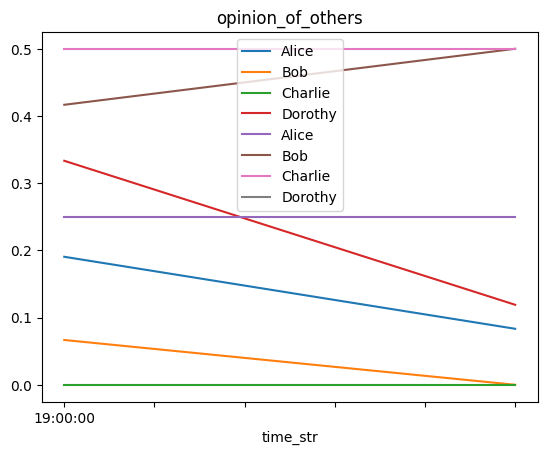

In [26]:
# @title Metrics plotting
import ipywidgets as widgets
import collections


group_by = collections.defaultdict(lambda: 'player')
group_by['opinion_of_others'] = 'of_player'

titles = [channel for channel in measurements.available_channels()]
children = [widgets.Output() for channel in measurements.available_channels()]

tb = widgets.Tab()
tb.children = children

for i in range(len(children)):
  tb.set_title(i, titles[i])
  with children[i]:
    plotting.plot_line_measurement_channel(measurements, titles[i], group_by=group_by[titles[i]], xaxis='time_str')



  
    
display.display(tb)

## Save results

In [ ]:
# @title Summarize the entire story.
all_gm_memories = env._memory.retrieve_recent(k=10000, add_time=True)

detailed_story = '\n'.join(all_gm_memories)
print('len(detailed_story): ', len(detailed_story))
# print(detailed_story)

episode_summary = model.sample_text(
    f'Sequence of events:\n{detailed_story}'+
    '\nNarratively summarize the above temporally ordered ' +
    'sequence of events. Write it as a news report. Summary:\n',
    max_characters=3500, max_tokens=3500, terminators=())
print(episode_summary)

In [ ]:
# @title Summarise the perspective of each player
player_logs = []
player_log_names = []
for player in players:
  name = player.name
  detailed_story = '\n'.join(player._memory.retrieve_recent(k=1000,
                                                            add_time=True))
  summary = ''
  summary = model.sample_text(
      f'Sequence of events that happened to {name}:\n{detailed_story}'
      '\nWrite a short story that summarises these events.\n'
      ,
      max_characters=3500, max_tokens=3500, terminators=())

  all_player_mem = player._memory.retrieve_recent(k=1000, add_time=True)
  all_player_mem = ['Summary:', summary, 'Memories:'] + all_player_mem
  player_html = html_lib.PythonObjectToHTMLConverter(all_player_mem).convert()
  player_logs.append(player_html)
  player_log_names.append(f'{name}')


#Build and display HTML log of the experiment

In [ ]:
history_sources = [env, direct_effect_externality, convo_externality]
histories_html = [
    html_lib.PythonObjectToHTMLConverter(history.get_history()).convert()
    for history in history_sources]
histories_names = [history.name() for history in history_sources]

In [ ]:
gm_mem_html = html_lib.PythonObjectToHTMLConverter(all_gm_memories).convert()

tabbed_html = html_lib.combine_html_pages(
    histories_html + [gm_mem_html] + player_logs,
    histories_names + ['GM'] + player_log_names,
    summary=episode_summary,
    title='Friends in a pub experiment',
)

tabbed_html = html_lib.finalise_html(tabbed_html)

In [ ]:
display.HTML(tabbed_html)

#Interact with a specific player

In [ ]:
sim_to_interact = 'Alice'  # @param ['Alice', 'Bob','Charlie', 'Dorothy', 'Ellen'] {type:"string"}
user_identity = 'a close friend'  # @param {type:"string"}
interaction_premise = f'{sim_to_interact} is talking to {user_identity}\n'  # @param {type:"string"}

player_names = [player.name for player in players]
player_by_name = {player.name: player for player in players}
selected_player = player_by_name[sim_to_interact]
interrogation = interaction_premise

In [ ]:
utterence_from_user = 'Did Bob accept your apology?'  # @param {type:"string"}

interrogation += f'{user_identity}: {utterence_from_user}'
player_says = selected_player.say(interrogation)
interrogation += f'\n{sim_to_interact}: {player_says}\n'
print(interrogation)